## 1. Descripción del problema y del dataset. 

Vamos a situarnos en Kenia, y nos vamos a imaginar que trabajamos para M-Pesa, https://es.wikipedia.org/wiki/M-Pesa.

Apto para utilizar en telefonos que puedan recibir SMS, y apoyandose en una amplia red de tiendas( agentes) colabororas, han venido a llenar el porblema del bajo indice de bancarización de estas sociedades y han llevado a Africa a ser lider mundial en Banca Online
los clientes pueden realizar las siguientes operaciones:

* CASH-IN: anmentar el saldo en su cuenta M-Pesa, entregando dinero en efectivo en la tienda.
* CASH-OUT: retirar efectivo contra el saldo de su cuenta  M-Pesa disminuyendo el  saldo de la cuenta. 
* DEBIT:  es un proceso similar al CASH-OUT e implica enviar el dinero del servicio de dinero móvil a una cuenta bancaria.
* PAYMENT: pago a comerciante, disminuye el saldo del cliente y aumenta el del comerciante. 
* TRANSFER: es el proceso de envío de dinero a otro usuario del servicio a través de la plataforma de dinero móvil.

En tres de los cinco tipos de transacciones(cash-in, cash-out, payment) hay un intermediario (comercio os sucursal de (M-PESA) involucrado. Suponemos que DEBIT y TRANSFER puede ser efectuado solo por el cliente ( o por el estafador).
Nos podemos imaginar que alos clientes están identificdos por la inicial c, y los agentes por la inical M.

Vamos a suponer el motivo principal de estafas, obtención fraudulenta de los datos de acceso por parte del estafador, y movimiento del saldo de la cuenta hacia efectivo o hacia otra u otras cuentas de M-PESA. Es muy posible que haya operacioens ocmbiandas, de transferencia y reintegro, utilizando cuentas de terceros ( mulas) para intentar no ser detectado.




In [1]:
import os, sys
#from google.colab import drive
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/fraud_detection/notebooks')
#!ls

In [2]:
# primero todas las librerías por bloques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# opciones de visualización
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [4]:
def plot_feature_2(df,col_name, isContinuous=True,target='isfraud'):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

    # Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + f' by {target}.')
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Fraud fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

## Funciones auxiliares

In [5]:
def plot_feature(df, col_name, target =  'isfraud'):
    '''
    Realiza la descripción gráfica de una catacteristica
    del proyecto. Realizará un histograma de col_name y un gráfico
    de barras de frecuencias relativas de col_neme en función de target.
    Del target solo histograma.
    
    Args:
    param1: Pandas Df de datos.
    param2: Característica a presentar en histograma.
    param3: Carácteristica para frecuencias relativas.
        
    Returns:
    Uno o dos gráficos de clases sns.
    '''
    # If target, only one plot..
    if col_name== target:
        f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,3), dpi=90)
        sns.countplot(x=df[target], ax=ax1);
        #ax1.bar_label(container=ax1.containers[0],label_type='center',weight='bold')
        ax1.set_xlabel(col_name)
        ax1.set_ylabel('Número')
      
    else:
        f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
        sns.countplot(x=df[col_name],
                      color='#5975A4', 
                      saturation=1,
                      ax=ax1)
        
        if df[col_name].nunique() <= 20:
            ax1.set_xlabel(col_name)
            plt.xticks(rotation = 90)
        else:
            ax1.axes.get_xaxis().set_ticks([])
        ax1.set_ylabel('Número clientes')
  

        # Construimos la tabla para el segundo gráfico
        data = (df.groupby(col_name)[target].
                value_counts(normalize=True).
                to_frame('proporción').
                reset_index())
        data_isfraud = data['isfraud'] == 1
        data = data[data_isfraud]

        
        data.columns = [col_name, target, 'proporción']
       
        sns.barplot(x = col_name,
                    y = 'proporción',
                     
                    data = data, 
                    saturation=1,
                    ax=ax2,
                    color='red')
        
        ax2.set_ylabel(target)
        ax2.set_title(target)
        
        if df[col_name].nunique() <= 20:
            ax2.set_xlabel(col_name)
            plt.xticks(rotation = 90)
           
        else:
            ax2.axes.get_xaxis().set_ticks([])

        plt.tight_layout()
        

In [6]:
def get_deviation_of_mean_perc(df, list_vars, target, multiplier):
   
    '''
    Realiza la clasificación de las caracterisiticas que presentan elementos
    con desviación superior la media y el producto de n * desviación estandar ,
    además de otros resultados realcionados.
    
    Args:
    param1: Pandas Df de datos.
    param2: Lista de columnas a revisar..
    param3: Columna objetivo para modelo.
    param4: Veces de sd a considerar en el cálculo de rango.
        
    Returns:
    Uno o dos gráficos de clases sns.
   '''
    pd_final = pd.DataFrame()
    
    for i in list_vars:
        
        mean = df[i].mean()
        sd = df[i].std()
        
        rango_norm=[mean - multiplier *sd,
                    mean + multiplier *sd]
        size_s = df[i].size
        
        
        perc_goods = df[(df[i]>=mean - multiplier *sd) & (df[i]<=mean + multiplier *sd)][i].size/size_s
        perc_excess = 1-perc_goods
        
        if perc_excess>0:

            pd_concat_percent=df[df[i].isin(rango_norm)][target]. \
                    value_counts(normalize=True).reset_index().drop('index',axis=1).T
            pd_concat_percent['feature']= i
            pd_concat_percent['outliers_count'] = perc_excess * size_s
            pd_concat_percent['porcentaje_outlires'] = perc_excess*100
           

            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True).sort_values('porcentaje_outlires',ascending=False)
            
    if pd_final.empty:
        print('No existen variables con outliers')
    return pd_final

In [7]:
def check_t_c(df):
  '''
    Controla si las operacioens son Transfer o Cash_out y si el importe 
    es igual a todo el oldbalanceorig de la cuenta origen. Vaciado de cuentas.

    Args:
    param1: Pandas Df de datos.
        
    Returns:
    Int 0,1 reperesentando valores booleanos.
   '''


  cond_1= (df['type'] == 'CASH_OUT')
  cond_2= (df['type'] == 'TRANSFER')
  cond_3= (df['amount'] == df['oldbalanceorg'])
  cond_final=((cond_1 | cond_2) & cond_3)
  return np.multiply(cond_final,1)


# Aproximación general a los datos.
* El dataset tiene 1.048.575 filas y 19 columnas.
* Solo una columna que parece que deber ser númerica ( conexion_time) figura como objeto.
* Solo tres columnas tienen Nans, alrededor de un 10 % en todos los casos. Todas categóricas, decidimos guardar la marca de una nueva categoría no disponible.
* Con el cambio indicado de conexion_type, tenemos 12 columnas númericas y 7 object.
* No existen filas duplicadas en todos los datos.


In [8]:
data_raw = pd.read_csv('../data/Copia de Original_dataset_payments_fraud.csv', delimiter =';')
data_raw.columns= data_raw.columns.str.lower()

In [9]:
data_raw.shape

(1048575, 19)

In [10]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              1048575 non-null  int64  
 1   type              1048575 non-null  object 
 2   amount            1048575 non-null  float64
 3   gender            943457 non-null   object 
 4   device            943995 non-null   object 
 5   connection_time   1048575 non-null  object 
 6   nameorig          1048575 non-null  object 
 7   race              943412 non-null   object 
 8   oldbalanceorg     1048575 non-null  float64
 9   age               1048575 non-null  int64  
 10  newbalanceorig    1048575 non-null  float64
 11  zone              944161 non-null   object 
 12  user_number       1048575 non-null  int64  
 13  namedest          1048575 non-null  object 
 14  user_connections  1048575 non-null  int64  
 15  security_alert    1048575 non-null  int64  
 16  

In [11]:
data_raw.head()

,step,type,amount,gender,device,connection_time,nameorig,race,oldbalanceorg,age,newbalanceorig,zone,user_number,namedest,user_connections,security_alert,oldbalancedest,newbalancedest,isfraud
0,1,PAYMENT,9839.6400,man,mac,"0,140039412",C1231006815,black,170136.0000,85,160296.3600,capital,138,M1979787155,5,1,0.0000,0.0000,0
1,1,PAYMENT,1864.2800,woman,mac,"0,496889534",C1666544295,asian,21249.0000,57,19384.7200,country,909,M2044282225,1,0,0.0000,0.0000,0
2,1,TRANSFER,181.0000,man,pc,"0,781150327",C1305486145,asian,181.0000,66,0.0000,capital,2569,C553264065,10,0,0.0000,0.0000,1
3,1,CASH_OUT,181.0000,man,mac,"0,565068378",C840083671,black,181.0000,31,0.0000,country,1787,C38997010,3,0,21182.0000,0.0000,1
4,1,PAYMENT,11668.1400,unknow,mac,"0,517114493",C2048537720,black,41554.0000,90,29885.8600,country,3997,M1230701703,8,0,0.0000,0.0000,0


In [12]:
# Correción dtype connection_type.
data_raw['connection_time'] = pd.to_numeric(data_raw['connection_time'].str.replace(',','.'),errors='coerce')

In [13]:
# Coprobamos Nans.
data_raw.isna().sum().sum()

419275

In [14]:
# Revisamos que ninguna columna contenga un único valor.
[column for column in data_raw.columns if data_raw[column].value_counts().index.shape[0]==1]    

[]

In [15]:
# Comprobamos existencia de filas duplicadas en todos los valores.
data_raw.duplicated().any()

False

#### Limpieza de Nans.
Dado que todas las categorias con nans son cardinales, vamos a completar los nans con 
un nuevo nivel dentro de la caegoria, 'not_disp', preservando el desconocido de gender
por sí aporta alguna información.

In [16]:
colums_with_nans=[column for column in data_raw.columns if  data_raw[column].isna().sum()>0]
data_raw[colums_with_nans].isna().sum()

gender    105118
device    104580
race      105163
zone      104414
dtype: int64

In [17]:
# Limpiamos Nans en 
data_raw[colums_with_nans]=data_raw[colums_with_nans].fillna('no_disp')
data_raw.isna().sum().sum()

0

In [18]:
data_raw.columns

Index(['step', 'type', 'amount', 'gender', 'device', 'connection_time',
       'nameorig', 'race', 'oldbalanceorg', 'age', 'newbalanceorig', 'zone',
       'user_number', 'namedest', 'user_connections', 'security_alert',
       'oldbalancedest', 'newbalancedest', 'isfraud'],
      dtype='object')

### Exploración de la variable objetivo y tratamiento.
La variable objetivo no necesita tratamiento.
Estamos ante unso datos muy desbalanceados, solo tenemos una proporción del 0.11 % de casos positivos, 1.142 casos positivos.

Iremos realizando una exploración bivariante con cada una de las caracterisiticas, y una amplia exploración de patrones temporales.

In [19]:
pd_plot_isfraud = data_raw['isfraud']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent_100').reset_index()

pd_plot_isfraud_conteo = data_raw['isfraud'].value_counts().reset_index()
pd_plot_isfraud_pc = pd.merge(pd_plot_isfraud, pd_plot_isfraud_conteo,
                              on=['index'], how='inner').rename(columns={'index':'valor'})
pd_plot_isfraud_pc

,valor,percent_100,isfraud
0,0,99.8911,1047433
1,1,0.1089,1142


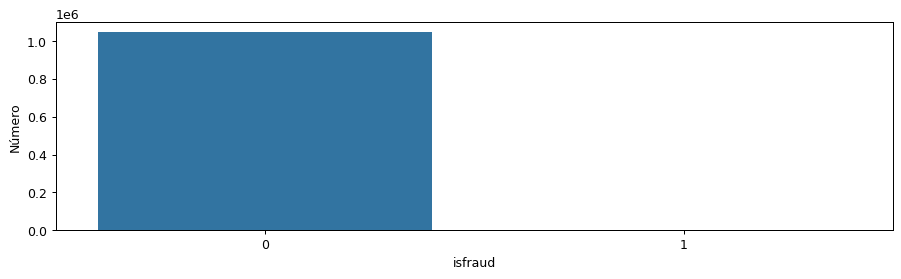

In [20]:
plot_feature(data_raw,'isfraud')

### Tipos: Variables categoricas y numericas

In [21]:
# Por observación de Head, sí tenemos que modificarla lo haremao.
naturaleza={'amount':'numeric',
            'connection_time':'numeric',
            'user_number' : 'numeric',
            'oldbalanceorg':'numeric',
            'newbalanceorig':'numeric',
            'oldbalancedest': 'numeric',
            'newbalancedest' : 'numeric',
            'user_connections': 'numeric',           
            'step' :'numerica',
            'age': 'numerica',
            
            'type': 'cardinal',
            'gender' : 'cardinal',
            'device' : 'cardinal',
            'nameorig' : 'cardinal',
            'race' : 'cardinal',
            'zone' : 'cardinal',
            
            'namedest' : 'cardinal',
            'security_alert': 'cardinal',
            'isfraud' : 'target'}

Creacion tabla metacaracteristicas.
Siempre resulta últil ir generando una tabla de metacaracterisiticas, de manera que nos permita ver de manera sintetica los datos que manejamos.

In [22]:
metadata=pd.DataFrame(data_raw.columns.tolist(),columns=['nombre'])
metadata['dtype']=data_raw.dtypes.tolist()
metadata['tipologia'] = metadata['nombre'].map(naturaleza)
metadata['valores_unicos']= metadata.apply(lambda x: data_raw[x['nombre']].nunique(dropna=False) ,axis=1)
metadata['5_mas_frecuentes'] = (metadata.apply(lambda x: data_raw[x['nombre']].
                                                 value_counts().index.tolist()[0:5],axis=1))
metadata['5_max_ocururrencias']=metadata.apply(lambda x: data_raw[x['nombre']].value_counts().tolist()[0:5],axis=1)
metadata

,nombre,dtype,tipologia,valores_unicos,5_mas_frecuentes,5_max_ocururrencias
0,step,int64,numerica,95,"[19, 18, 43, 15, 17]","[51352, 49579, 45060, 44609, 43361]"
1,type,object,cardinal,5,"[CASH_OUT, PAYMENT, CASH_IN, TRANSFER, DEBIT]","[373641, 353873, 227130, 86753, 7178]"
2,amount,float64,numeric,1009606,"[10000000.0, 706.25, 1711.67, 3172.71, 5838.16]","[14, 6, 5, 5, 5]"
3,gender,object,cardinal,4,"[woman, unknow, man, no_disp]","[366906, 314307, 262244, 105118]"
4,device,object,cardinal,4,"[mac, pc, iphone, no_disp]","[367066, 314867, 262062, 104580]"
5,connection_time,float64,numeric,1047989,"[0.428902039, 0.589906316, 0.819925197, 0.4377...","[2, 2, 2, 2, 2]"
6,nameorig,object,cardinal,1048317,"[C1214450722, C309111136, C1268675361, C720460...","[2, 2, 2, 2, 2]"
7,race,object,cardinal,4,"[asian, black, latin, no_disp]","[366338, 314755, 262319, 105163]"
8,oldbalanceorg,float64,numeric,415945,"[0.0, 109.0, 195.0, 147.0, 141.0]","[342214, 167, 161, 160, 159]"
9,age,int64,numerica,96,"[52, 71, 12, 65, 73]","[11155, 11138, 11118, 11094, 11089]"


In [23]:
categorical_list=metadata[metadata.tipologia=='cardinal']['nombre']
numerical_list= metadata[metadata.tipologia=='numeric']['nombre']
target='isfraud'

In [24]:
# Transform categorical variabels to dtype category.
data_raw[categorical_list] = data_raw[categorical_list].astype("category")

## Detección de ouliers en variables númericas.
Tomando 3 veces de intervalo de desviación típica sobre la media nos dan % de oultiers de entre un 1.8 y un 2.5 %. Los consideramos normales dada la naturaleza de los datos. Son importes dinerarios de operaciones bancarias, donde la cola inferior no puede ser menor que cero, y las cantidades se extienden hasta el limite máximo por transacción que en este caso parece que son 10.000.000. 
No consideramos necesario eliminar ningun caso.

In [25]:
get_deviation_of_mean_perc(data_raw, numerical_list, 'isfraud',3)

,feature,outliers_count,porcentaje_outlires
0,newbalanceorig,26282.0000,2.5064
1,oldbalanceorg,26140.0000,2.4929
4,newbalancedest,22862.0000,2.1803
2,oldbalancedest,22685.0000,2.1634
3,amount,19422.0000,1.8522


In [26]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
step,1048575.0000,26.9662,15.6233,1.0000,15.0000,20.0000,39.0000,95.0000
amount,1048575.0000,158666.9755,264940.9304,0.1000,12149.0650,76343.3300,213761.8900,10000000.0000
connection_time,1048575.0000,0.5001,0.2885,0.0000,0.2501,0.5004,0.7497,1.0000
oldbalanceorg,1048575.0000,874005.5356,2971725.1982,0.0000,0.0000,16002.0000,136642.0200,38939424.0300
age,1048575.0000,52.4567,27.7264,5.0000,28.0000,52.0000,76.0000,100.0000
newbalanceorig,1048575.0000,893804.8536,3008245.7978,0.0000,0.0000,0.0000,174599.9900,38946233.0200
user_number,1048575.0000,2530.4398,1426.4177,59.0000,1295.0000,2532.0000,3765.0000,5000.0000
user_connections,1048575.0000,5.5036,2.8722,1.0000,3.0000,6.0000,8.0000,10.0000
oldbalancedest,1048575.0000,978159.9661,2296779.3605,0.0000,0.0000,126377.2100,915923.4750,42054659.7300
newbalancedest,1048575.0000,1114193.2651,2416554.4402,0.0000,0.0000,218260.3600,1149807.5100,42169156.0900


In [27]:
# Save clean datas.
data_raw.to_parquet('../data/fraud_detection_clean.parquet',
              compression='gzip')

metadata.astype(str).to_parquet("../data/metadata_fraud.parquet") 

### EDA. ¿ Dividimos en train-test antes o después del EDA?. Feature engenering en EDA.
No soy pragmatico con este tema, mi opinión hasta que surjió la discursión en clase, era hacer el EDA sobre todo el dataset disponible. Comprendí que asislando el test antes del eda, podemos decir que estamos menos influenciados por los datos "ocultos". Y a partir de ahora, me plantearé cuando empiece un modelo que decisión tomar.

Despues de conocer lo visto para ese conjunto de datos, la decisión es hacer el EDA con todo el dataset, por una razón fundamental. Tenemos al menos dos caracteristicas muy desbalanceadas, isfraud y steps. Podemos controlar la esteafificación del target, pero con mucha seguridad nos deje fuera alguno de los 95 pasos de step, Cuestión que nos haría perder información en el EDA. La solución ideal sería implementar muestreo estratificado anidado por steps, pero considero que los avances que porduzca no reportarán mejoras al modelo.

Hacemos EDA con dataset completo.

A lo largo de este EDA, se van a añadir caracteristicas a nuestros datos: dado que el EDA es un proceso inteactivo de comprensión de los datos, pensamos que sí existe alguna caracteristica que nos faciita la comprensión de los mismos, es un buen momento para añadirla.



### Step. Escala temporal.
Vamos a estudiar un profundidad la escala temporal de las operaciones y de los fraudes.

Se nos indica que step corresponde a una hora de tiempo. Se va incrementando de uno e uno, pero nos permite transformarlo en cualquier midida de tiempo mayor, día, etc.

Tenemos datos de 4 dias de transacciones, tres días y 23 horas (95).  Añadimos columnas de día y hora, sin eliminar step, ya veremoo despúes sí es conveniente para los modelos eliminarlas.

Si consideramos la hora de 00:00 a 01:00 como la hora 1, los ciclos se adaptan a los horarios de cualquier actividad comericial que requiera presencia en un comercio o punto automatico de atención, muy bajo por la noche, creciente por la mañana y alcanza su pico entre 18:00 y 19:00 cuando el  público ha terminado su joranda laboral.

El 97 % de las operaciones se producen en los días 1 y 2. Los días 3 y 4 podemos afirmar que las operacioones son testimoniales. Los dos priemros días se producen de media 23.793 y 18865 respectivamente, bajando los días 3 y 4 a 281 y 751. No ocnocemos la razón de tan baja actividad los días 3 y 4.


<AxesSubplot:xlabel='step'>

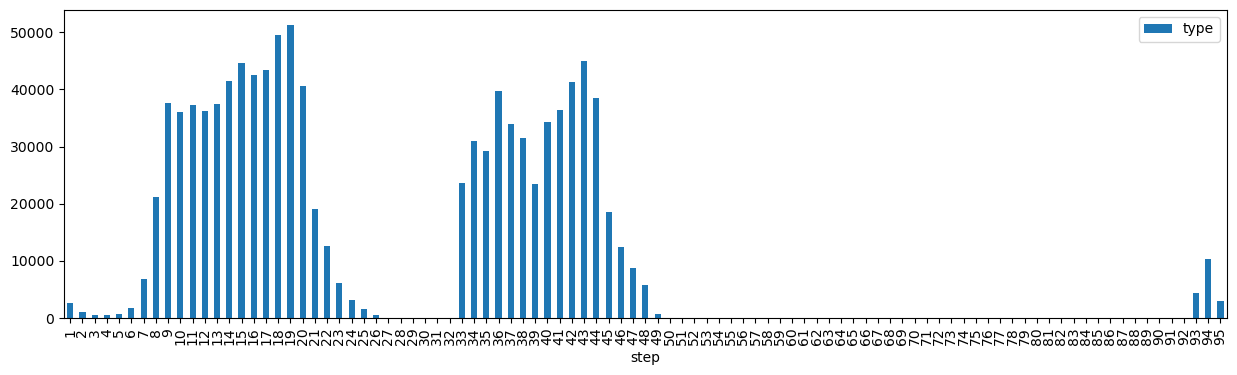

In [28]:
# Ploteamos las cuenta de operaciones por step.
data_raw[['type','step']].groupby('step').count().plot(kind='bar',figsize=(15,4))

<AxesSubplot:xlabel='step'>

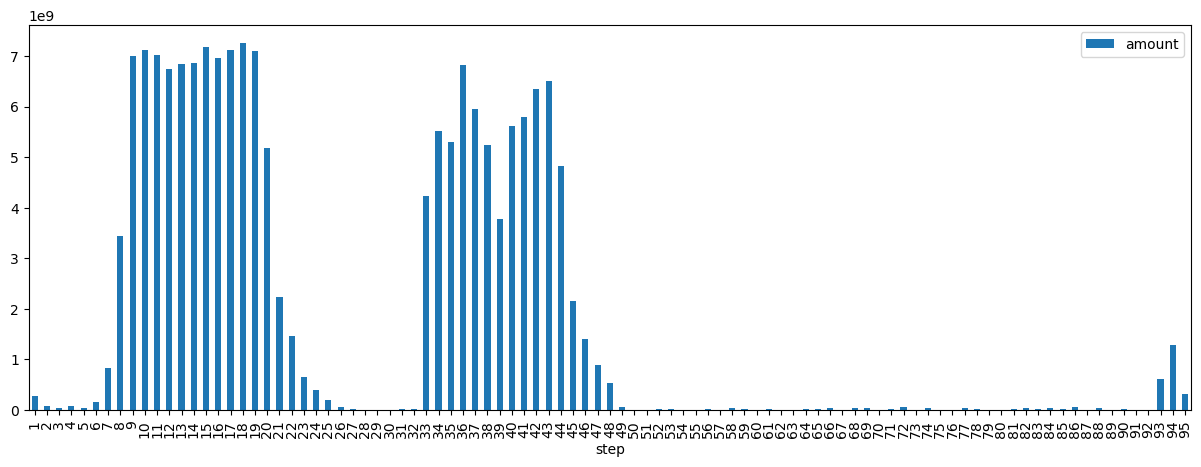

In [29]:
# Ploteamos las suma importes de operaciones por step.
data_raw[['amount','step']].groupby('step').sum().plot(kind='bar',figsize=(15,5))

In [30]:
# Si los datos se corresponden con horas podemos inferir muy rápido el día y la hora.
# El día es relativo al comienzo de la primera transacción.
# la Hora suponemos que empieza a las 00:00 de un día.

data_raw['dia'] = (data_raw['step'] // 24)+1
data_raw['hora']= data_raw['step'] % 24

<AxesSubplot:>

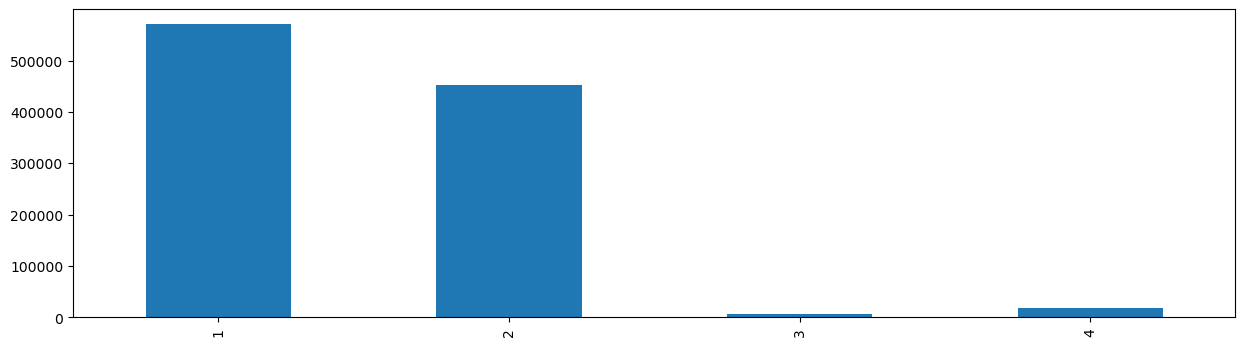

In [31]:
# Vemos el total de operaciones por dia en los 4 dias.
data_raw.dia.value_counts().sort_index().plot(kind='bar',figsize=(15,4))

<AxesSubplot:>

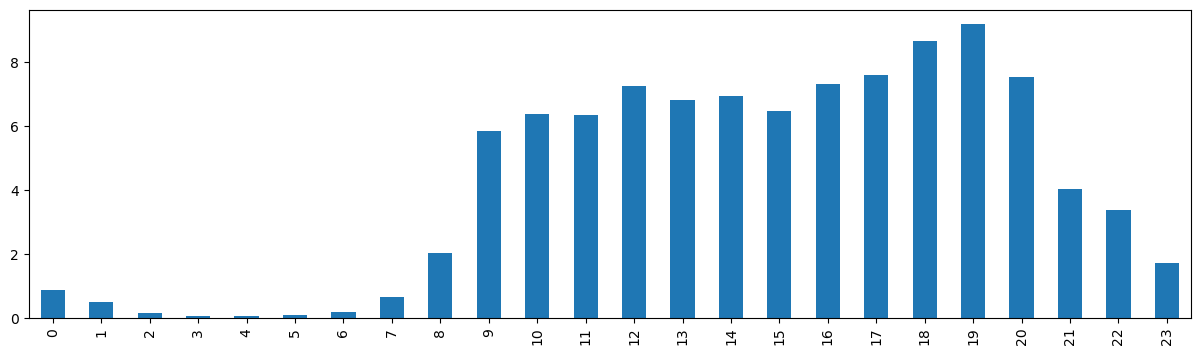

In [32]:
# Revisamos el total de operaciones por horas
(data_raw.hora.value_counts(normalize=True)*100).sort_index().plot(kind='bar',figsize=(15,4))

### Patrones temporales del fraude.
A pesar de la abultada desproporción en el número de operaciones entre los steps en todos ellos se producen operaciones de fraude. Y están muy balanceados los casos de fraude por ste, entre un máximo de 24 fraudes y un mínimo de 2.
 




In [33]:
# Check number stpes with fraud.
data_raw[data_raw.isfraud==1]['step'].nunique()

95

Se produce una media de 12 fraudes a la hora, un máximo de 24 fraudes y un mínimo de dos fraudes. Dada la variabilidad del número de operaciones, parece que el fraude presenta menos variación. 

<AxesSubplot:xlabel='step'>

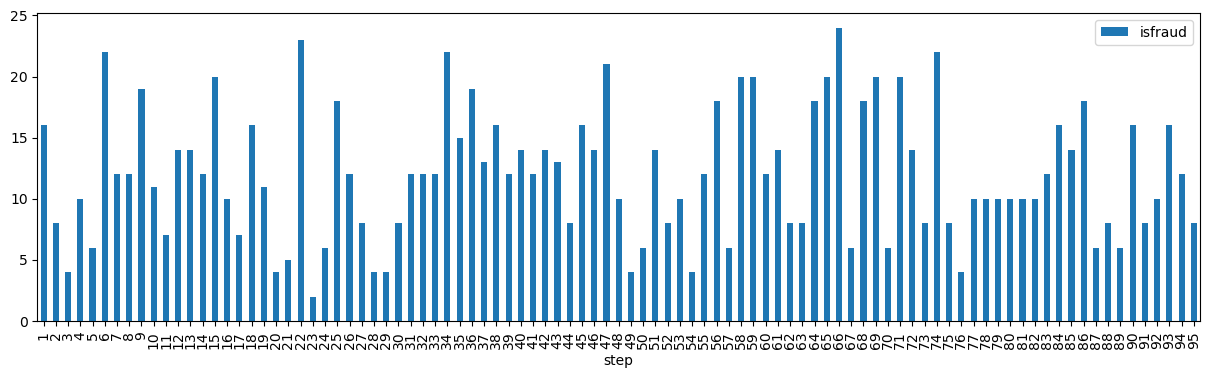

In [34]:
data_raw[data_raw.isfraud==1][['isfraud','step']].groupby('step').sum().plot(kind='bar',figsize=(15,4))

In [35]:
data_raw[data_raw.isfraud==1][['isfraud','step']].groupby('step').sum().describe().T

,count,mean,std,min,25%,50%,75%,max
isfraud,95.0000,12.0211,5.2995,2.0000,8.0000,12.0000,16.0000,24.0000


Acumulando todas las horas de los 4 días aun parece estabilizarse mas. LA hora que mas fraudes totaliza son 70, las 18 horas coherente con la hora de máxima actividad de los días 1 y 2. El mínimo son 26 al as 4 de la mañana.

<AxesSubplot:xlabel='hora'>

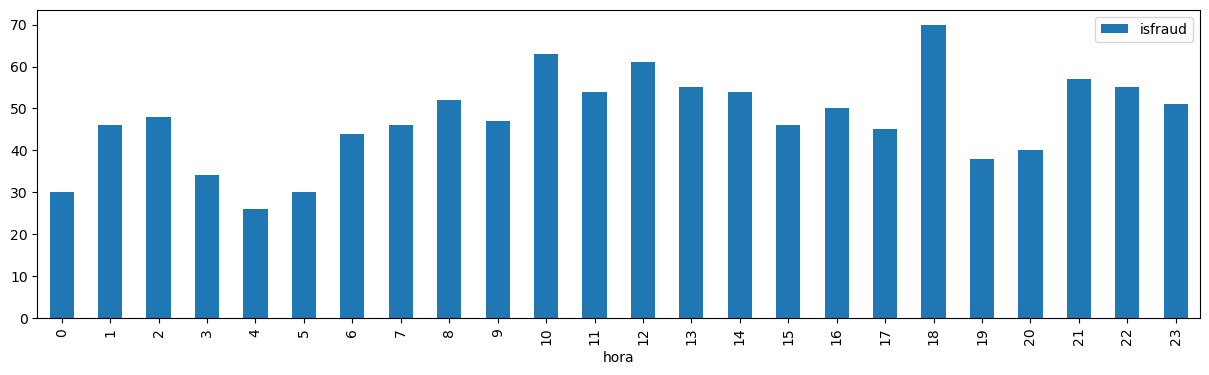

In [36]:
(data_raw[['hora','step','isfraud']].groupby(['hora']).
                                             agg({'isfraud':'sum'}).plot(kind='bar',figsize=(15,4)) )

In [37]:
(data_raw[['hora','isfraud']].groupby(['hora']).agg({'isfraud':'sum'})).describe().T

,count,mean,std,min,25%,50%,75%,max
isfraud,24.0000,47.5833,10.8022,26.0000,43.0000,47.5000,54.2500,70.0000


### Step
#### Estudio de la proporción de casos de fraude por step.

Encontramos un patrón muy dicótomico. El fraude tiene proporciones muy bajas en las horas en las horas de actividad normal. Pero cuando producen un número muy bajo de operaciones se va al 100 %. Este hecho ocurre en 48 de los 95 periodos de nuestro set de datos.

En esos steps donde todas las operaciones son fraudulentas se realizan 562 operaciones, que sí bien en el todas de operacioens es un porcentaje infimo, es ALGO MENOS DE LA MITAD DE LOS CASO DE FRAUDE. Podemos extraer una conclusión, LOS CASOS DE FRAUDE SE CONCENTRAN EN LAS PRIMERAS OPERACIOENS DE CADA STEP.



In [38]:
fraud_frame=data_raw[['dia','hora','isfraud']].groupby(['dia','hora'],as_index=False).agg(['count'])
fraud_frame.columns = fraud_frame.columns.droplevel(0)
fraud_frame['num_fraude']=data_raw[['dia','hora','isfraud']].groupby(['dia','hora']).agg(['sum'])
fraud_frame['proporcion']=fraud_frame['num_fraude']/fraud_frame['count']*100
fraud_frame= fraud_frame.reset_index()

In [39]:
fraud_frame

,dia,hora,count,num_fraude,proporcion
0,1,1,2708,16,0.5908
1,1,2,1014,8,0.7890
2,1,3,552,4,0.7246
3,1,4,565,10,1.7699
4,1,5,665,6,0.9023
5,1,6,1660,22,1.3253
6,1,7,6837,12,0.1755
7,1,8,21097,12,0.0569
8,1,9,37628,19,0.0505
9,1,10,35991,11,0.0306


<AxesSubplot:>

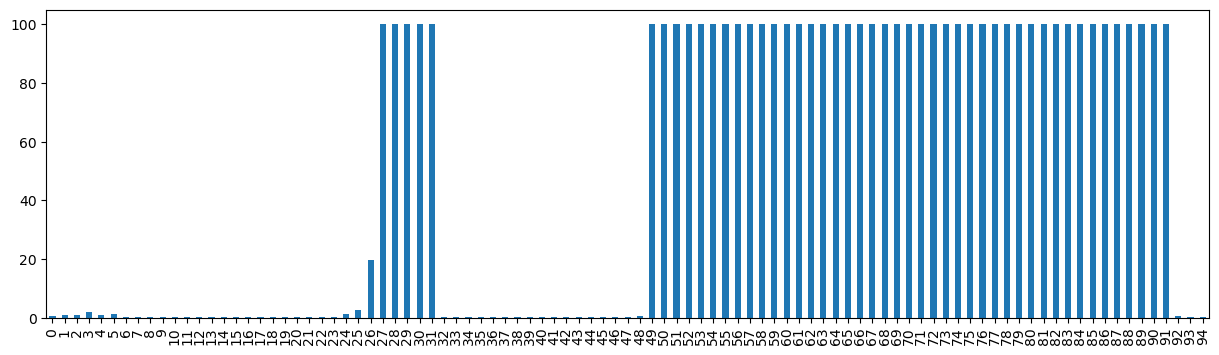

In [40]:
fraud_frame['proporcion'].plot(kind='bar',figsize=(15,4))

In [41]:
# NUmero de periodos en que todas las operacioens son fraude.
fraud_frame[fraud_frame['proporcion']==100].shape[0]

48

In [42]:
# Numero de fraudes comietidos cuando todas las operacioens de esa hora son fraude.
fraud_frame[fraud_frame['proporcion']==100]['num_fraude'].sum()

562

A la vista que se produce fraude en todos los steps, que en los steps que hay pocas operaciones la porporción de fraude es muy alta. Consideramos interesante incorporar un contador parcial de operaciones dentros de cada step.
Añadimos tambien un contador de fraude dentros de cada step y  a patir de este proporción que va suponiendo la operación dentro del stop, así cuando hay una ´nica operación, supone el 100 % de las operacioens, cuando hay 10, la última operación supone un 10 %, 100 operacioens, 1 %.....

Nuestra teoria se ve refrendada: LA MITAD DEL LOS 1.142 CASOS DE FRAUDE SE PRODUCEN EN LOS 27 PRIMERAS OPERACIOENS DE CADA STEP.
LAs operaciones con alta importancia son mas proclives a ser fraude.

In [43]:
# contador orden in step
data_raw['step_order']=data_raw.groupby('step').cumcount()+1


In [44]:
# Vemos el peso relativo que va suponiendo la operacion en cada step.
data_raw['step_importance']=np.power(data_raw['step_order'].astype(float),-1)

In [45]:
# Numero de orden de fraude dentro de cada step.
data_raw['fraud_order']=data_raw[['step','isfraud']].groupby('step').agg({'isfraud':'cumsum'})


In [46]:
fraud_by_position=data_raw[['isfraud','step_order']].groupby('step_order').sum()

<AxesSubplot:xlabel='step_order'>

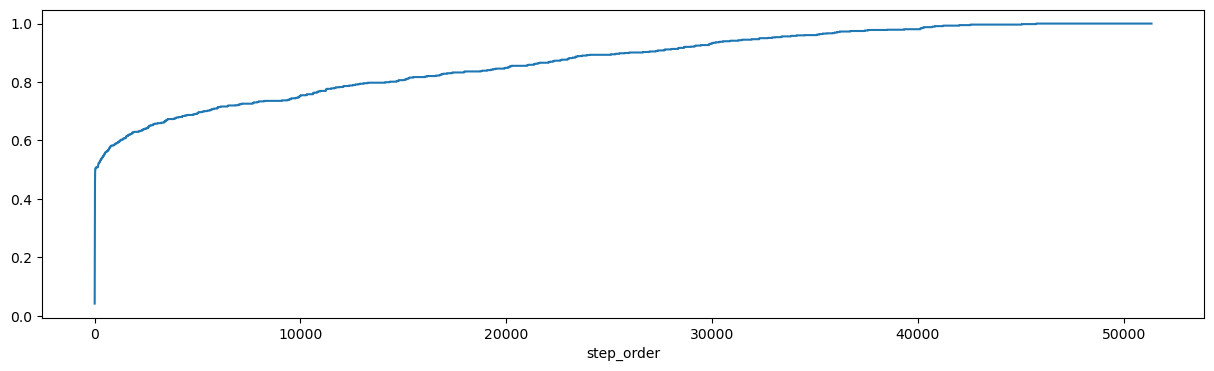

In [47]:
fraud_by_position['acumulado']=fraud_by_position['isfraud'].cumsum()
fraud_by_position['porc_acumulado']= fraud_by_position['acumulado']/fraud_by_position['acumulado'].max()
fraud_by_position['porc_acumulado'].plot(figsize=(15,4))

<AxesSubplot:xlabel='step_order'>

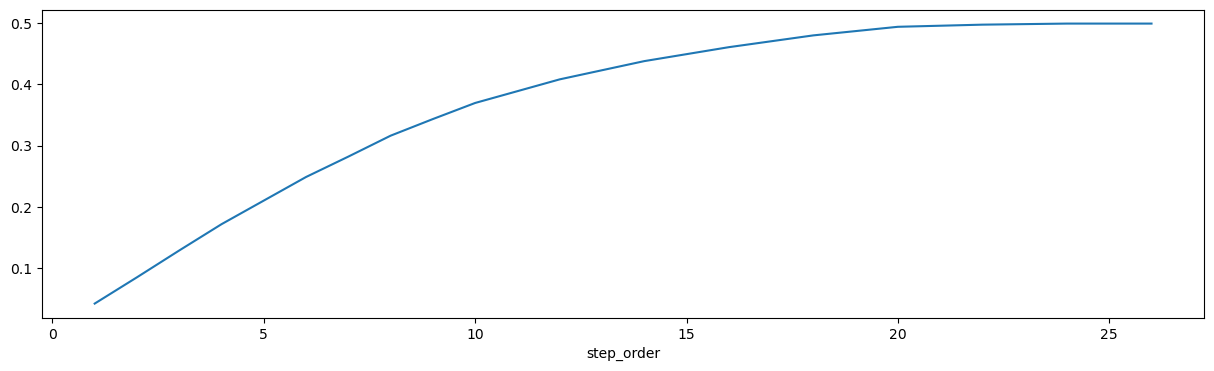

In [48]:
fraud_by_position[fraud_by_position['porc_acumulado']<0.5]['porc_acumulado'].plot(figsize=(15,4))

###  Type.

LAs operaciones mas frecuentes con CASH_OUTy PAYMENT, con un 35 y 33 % de las operaciones. 

Solo se producen operacioens de fraude en dos de las 5 tipos de operaciones, CASH_OUT Y TRANSFER, con un número muy equibrados entre ellos, 578 y 564 respectivamente. Dado el menor número de transferencias la proprocón de transferencias fraudulentas cuatriplica la proporción de reintegros fraudulentos.




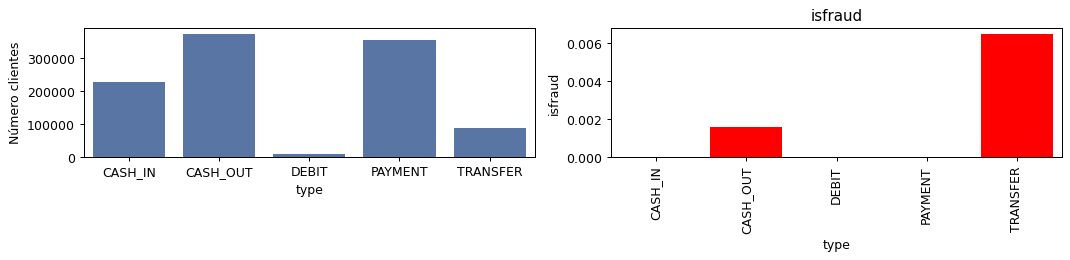

In [49]:
plot_feature(data_raw, 'type')

In [50]:
tabla_value=data_raw.type.value_counts().to_frame()
tabla_value['proporcion']=data_raw.type.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']
tabla_value

,operaciones,proporcion
CASH_OUT,373641,35.6332
PAYMENT,353873,33.7480
CASH_IN,227130,21.6608
TRANSFER,86753,8.2734
DEBIT,7178,0.6845


In [51]:
data_raw[['type','isfraud']].groupby('type').agg([sum,'mean'])

isfraud       
             sum   mean
type                   
CASH_IN        0 0.0000
CASH_OUT     578 0.0015
DEBIT          0 0.0000
PAYMENT        0 0.0000
TRANSFER     564 0.0065

### Amount. 
De la observación de amount se observa:

1) Como los pagos en comerciso son de un importe pequeño.

2) Como no exsiten grandes ingresos, ni operacioens de debit.

Y como en CASH_OUT y TRANSFERS, existen operaciones de un rango mucho mas elevado de importes:

1) De la simple observación del gráfico vemos un paralelismo en que las operacioens de fraude parecen implicar una transferencia y un cash_out.

2) El importe mas alto que no es fraude es 6.419.835. Tanto los cash_outs como las transferencias de importe mas alto son fraude.

3) Existe un hecho muy curioso, las transacciones de mas de 6.419.835, que son todo fraudes, hay un patrón bien se hace una transferencia por el importe y despues un cash_out, o bien se hace una transferencia por 10 millones y un cash out de 10 millones. Y las operacioens de cash_out son inmediatas a la transferencia. 

In [52]:
data_raw.amount.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
amount,1048575.0000,158666.9755,264940.9304,0.1000,12149.0650,76343.3300,213761.8900,10000000.0000


<AxesSubplot:xlabel='amount', ylabel='type'>

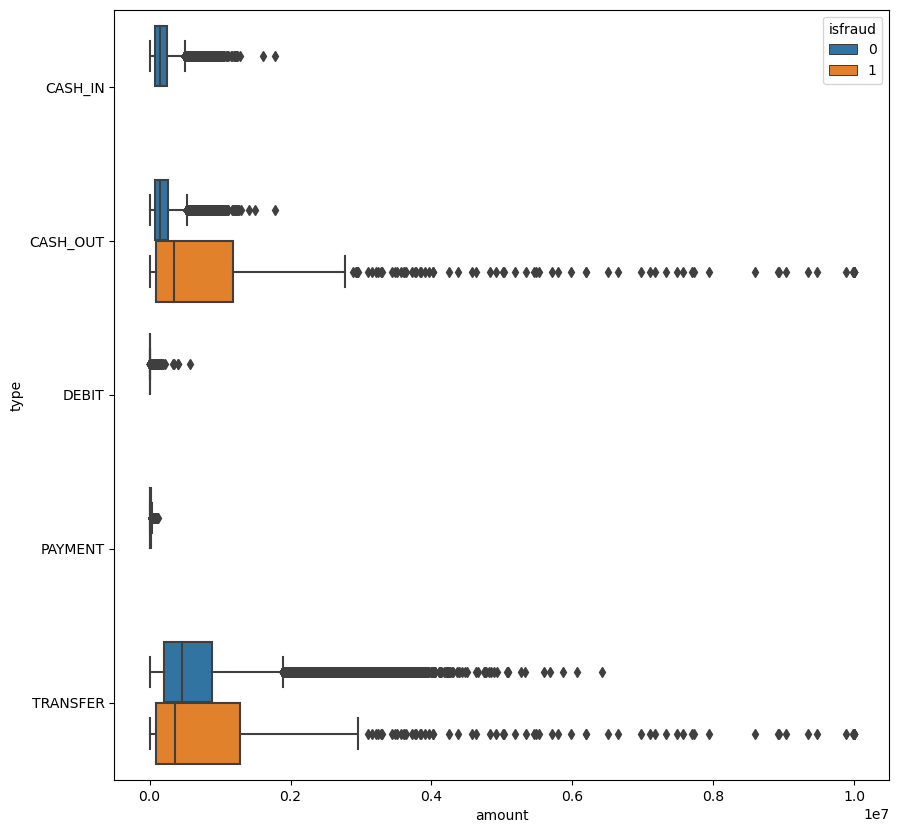

In [53]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(10,10))
sns.boxplot(y = 'type', x = 'amount', hue='isfraud',data = data_raw)


In [54]:
data_raw[data_raw.amount>6419835]

,step,type,amount,gender,device,connection_time,nameorig,race,oldbalanceorg,age,newbalanceorig,zone,user_number,namedest,user_connections,security_alert,oldbalancedest,newbalancedest,isfraud,dia,hora,step_order,step_importance,fraud_order
4440,4,TRANSFER,10000000.0000,woman,no_disp,0.9462,C7162498,latin,12930418.4400,61,2930418.4400,africa,137,C945327594,3,0,0.0000,0.0000,1,1,4,167,0.0060,1
4441,4,CASH_OUT,10000000.0000,no_disp,iphone,0.0120,C351297720,black,10000000.0000,19,0.0000,capital,4952,C766681183,9,1,0.0000,9941904.2100,1,1,4,168,0.0060,2
84416,10,TRANSFER,6419835.2700,man,pc,0.8377,C890128330,black,31784.0000,99,0.0000,capital,4077,C1192472312,6,0,0.0000,6691744.8500,0,1,10,11691,0.0001,3
481250,19,TRANSFER,10000000.0000,unknow,pc,0.8687,C416779475,asian,11861008.3200,6,1861008.3200,country,4768,C380259496,1,0,0.0000,0.0000,1,1,19,40120,0.0000,8
481251,19,CASH_OUT,10000000.0000,woman,iphone,0.1339,C2050703310,latin,10000000.0000,36,0.0000,no_disp,4089,C1622860679,7,0,504326.6200,10342417.9000,1,1,19,40121,0.0000,9
586311,33,TRANSFER,10000000.0000,man,pc,0.7632,C1439740840,black,19887819.0600,23,9887819.0600,africa,2574,C875288652,9,0,0.0000,0.0000,1,2,9,9938,0.0001,5
586312,33,CASH_OUT,10000000.0000,unknow,iphone,0.2052,C29118015,asian,10000000.0000,16,0.0000,no_disp,1569,C1379703840,8,0,0.0000,10000000.0000,1,2,9,9939,0.0001,6
586313,33,TRANSFER,9887819.0600,woman,no_disp,0.9403,C1548903046,latin,9887819.0600,58,0.0000,country,4905,C2065423383,9,0,0.0000,0.0000,1,2,9,9940,0.0001,7
586314,33,CASH_OUT,9887819.0600,woman,mac,0.5770,C1071702423,latin,9887819.0600,52,0.0000,africa,1815,C28783325,6,0,801913.9500,10165200.1100,1,2,9,9941,0.0001,8
597895,33,TRANSFER,6648389.9000,no_disp,no_disp,0.9071,C67311634,asian,6648389.9000,63,0.0000,africa,3365,C674603923,7,0,0.0000,0.0000,1,2,9,21522,0.0000,11


### Genero
Dado que exisen muchos datos desconocidos o no disponibles, no pensamso que pueda aportar mucho. Cuando además no encontramos ninguna diferencia entre los porcentajes de operciones fraudulentas que se producen.



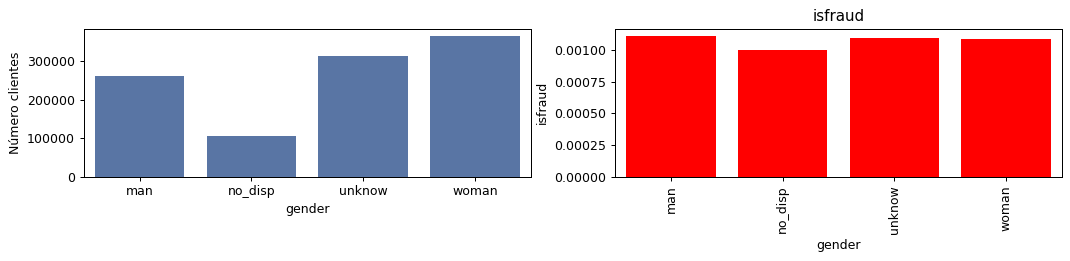

In [55]:
plot_feature(data_raw, 'gender')

In [56]:
tabla_value=data_raw.gender.value_counts().to_frame()
tabla_value['proporcion']=data_raw.gender.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']
tabla_value

,operaciones,proporcion
woman,366906,34.9909
unknow,314307,29.9747
man,262244,25.0096
no_disp,105118,10.0248


In [57]:
data_raw[['gender','isfraud']].groupby('gender').agg([sum,'mean'])

isfraud       
            sum   mean
gender                
man         293 0.0011
no_disp     105 0.0010
unknow      344 0.0011
woman       400 0.0011

### Device
Obtenemos la información de que mas todos se usan en la misma contidad y no se aprecia diferencia en tipo de dispositivo en el fraude, tenemos valores missing, pero esta variable no aporta parece aportar demasiada información. 

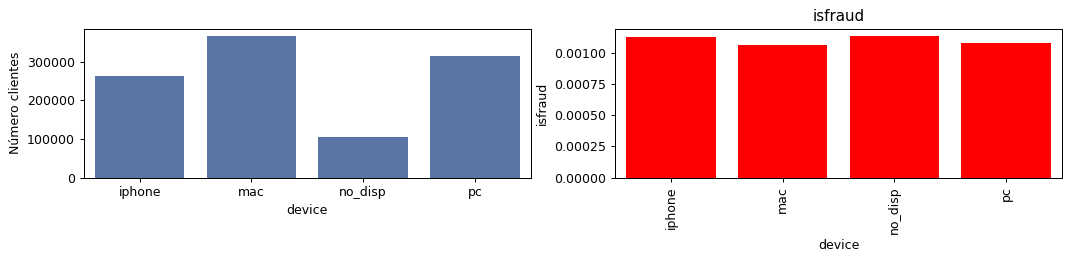

In [58]:
plot_feature(data_raw, 'device')

In [59]:
tabla_value=data_raw.device.value_counts().to_frame()
tabla_value['proporcion']=data_raw.device.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']
tabla_value

,operaciones,proporcion
mac,367066,35.0062
pc,314867,30.0281
iphone,262062,24.9922
no_disp,104580,9.9735


In [60]:
data_raw[['device','isfraud']].groupby('device').agg([sum,'mean'])

isfraud       
            sum   mean
device                
iphone      295 0.0011
mac         389 0.0011
no_disp     119 0.0011
pc          339 0.0011

### Conexion_time.
Solo a la vista del box-plot se puede afirmar que no va a ayudar a predecir la posibilidad de fraude.


In [61]:
data_raw.connection_time.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
connection_time,1048575.0000,0.5001,0.2885,0.0000,0.2501,0.5004,0.7497,1.0000


<AxesSubplot:xlabel='connection_time', ylabel='type'>

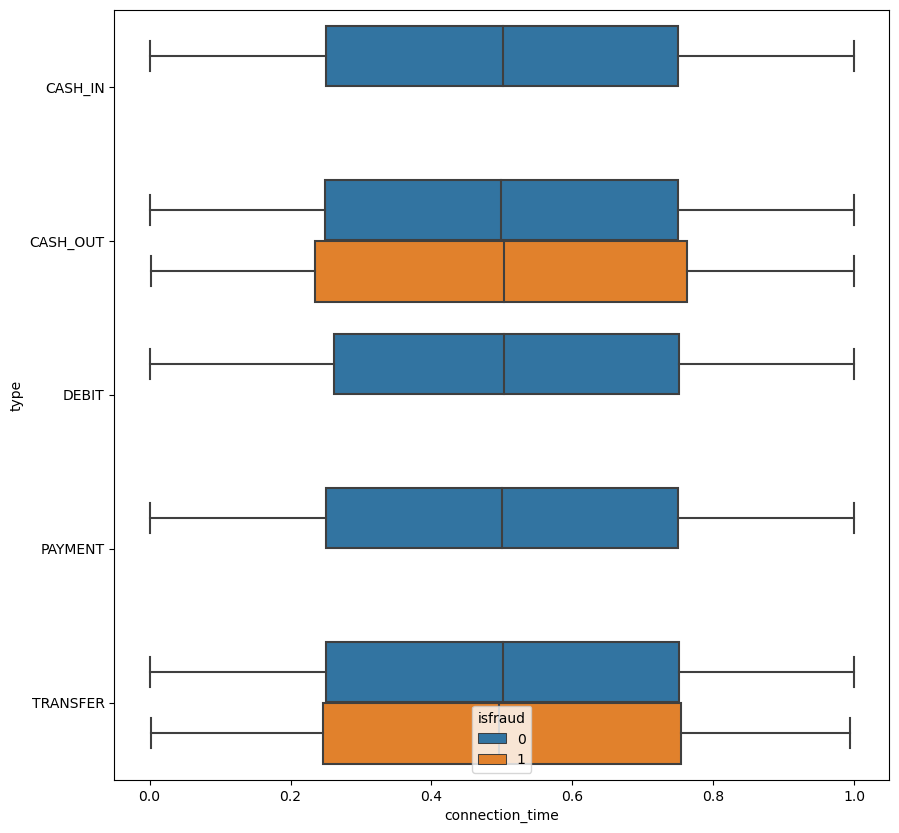

In [62]:
fig, ax = pyplot.subplots(figsize=(10,10))
sns.boxplot(y = 'type', x = 'connection_time', hue='isfraud',data = data_raw)

### Race

Obtenemos la información de que mas asiaticos realizan transacciones, todas las razas tienen unos valores semejantes en cometimiento de fraude .La raza no parece ser un factor clave a la hora de la realización del estudio.

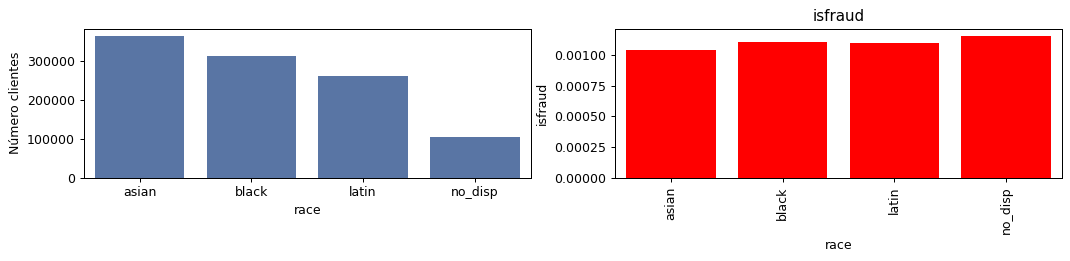

In [63]:
plot_feature(data_raw, 'race')

In [64]:
tabla_value=data_raw.race.value_counts().to_frame()
tabla_value['proporcion']=data_raw.race.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']
tabla_value

,operaciones,proporcion
asian,366338,34.9367
black,314755,30.0174
latin,262319,25.0167
no_disp,105163,10.0291


In [65]:
data_raw[['race','isfraud']].groupby('race').agg([sum,'mean'])

isfraud       
            sum   mean
race                  
asian       383 0.0010
black       349 0.0011
latin       288 0.0011
no_disp     122 0.0012

### Zona

Caracteristica que no parece tener ningana utilidad para entender el fraude.

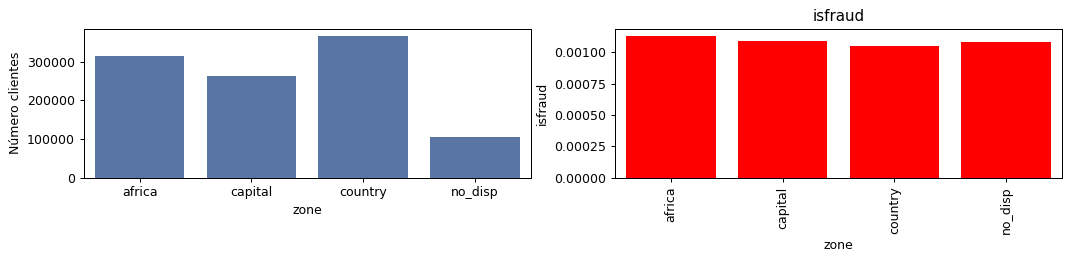

In [66]:
plot_feature(data_raw, 'zone')

In [67]:
tabla_value=data_raw.zone.value_counts().to_frame()
tabla_value['proporcion']=data_raw.zone.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']
tabla_value

,operaciones,proporcion
country,368004,35.0956
africa,314026,29.9479
capital,262131,24.9988
no_disp,104414,9.9577


In [68]:
data_raw[['zone','isfraud']].groupby('zone').agg([sum,'mean'])

isfraud       
            sum   mean
zone                  
africa      356 0.0011
capital     286 0.0011
country     387 0.0011
no_disp     113 0.0011

### User number.

Parece otra columna fake, sigue los mismos patrones en los box-plot de columans que no parecen aportar nada para explicar el fraude.

In [69]:
data_raw.user_number.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
user_number,1048575.0000,2530.4398,1426.4177,59.0000,1295.0000,2532.0000,3765.0000,5000.0000


<AxesSubplot:xlabel='user_number', ylabel='type'>

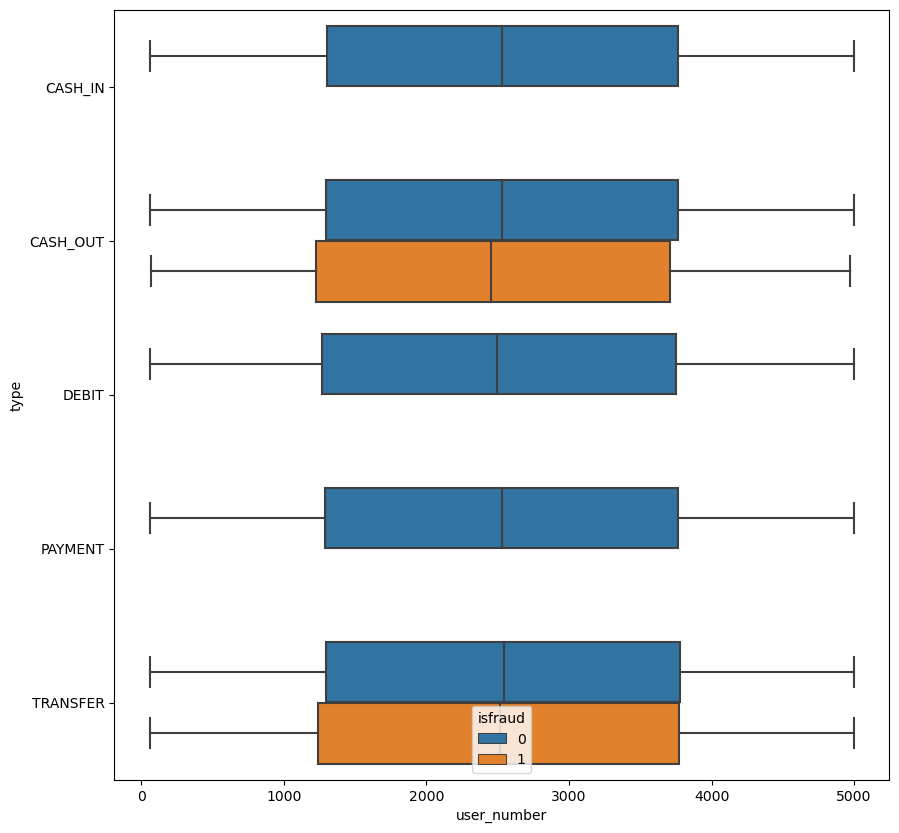

In [70]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(10,10))
sns.boxplot(y = 'type', x = 'user_number', hue='isfraud',data = data_raw)

### Security_alert

Aunque parecía un campo prometedor, parece que no va a ser de gran utilidad, solo coincide con operacioens de fraude en 117 ocasiones. Por lo que no le prestmamos mucha mas atención.

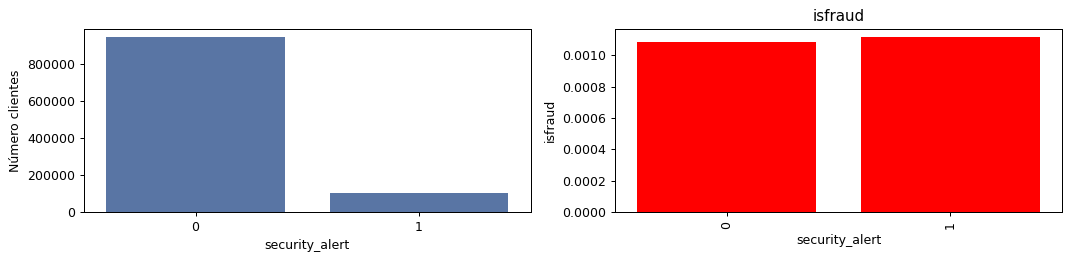

In [71]:
plot_feature(data_raw,'security_alert')

In [72]:
tabla_value=data_raw.security_alert.value_counts().to_frame()
tabla_value['proporcion']=data_raw.security_alert.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']
tabla_value

,operaciones,proporcion
0,943670,89.9955
1,104905,10.0045


In [73]:
data_raw[['security_alert','isfraud']].groupby('security_alert').agg([sum,'mean'])

isfraud       
                   sum   mean
security_alert               
0                 1025 0.0011
1                  117 0.0011

### Age

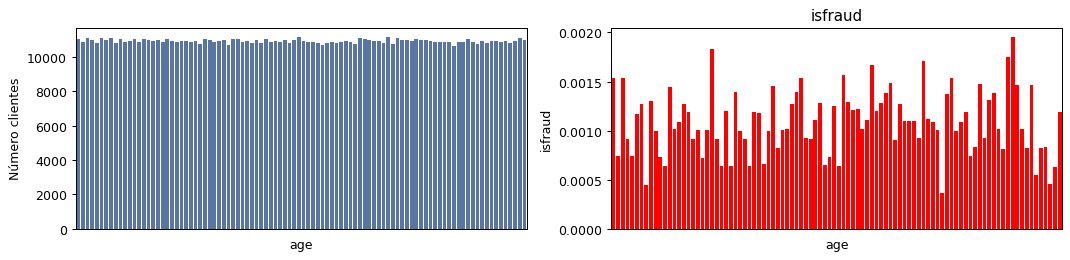

In [74]:
plot_feature(data_raw, 'age')

In [75]:
data_raw.age.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
age,1048575.0000,52.4567,27.7264,5.0000,28.0000,52.0000,76.0000,100.0000


<AxesSubplot:xlabel='age', ylabel='type'>

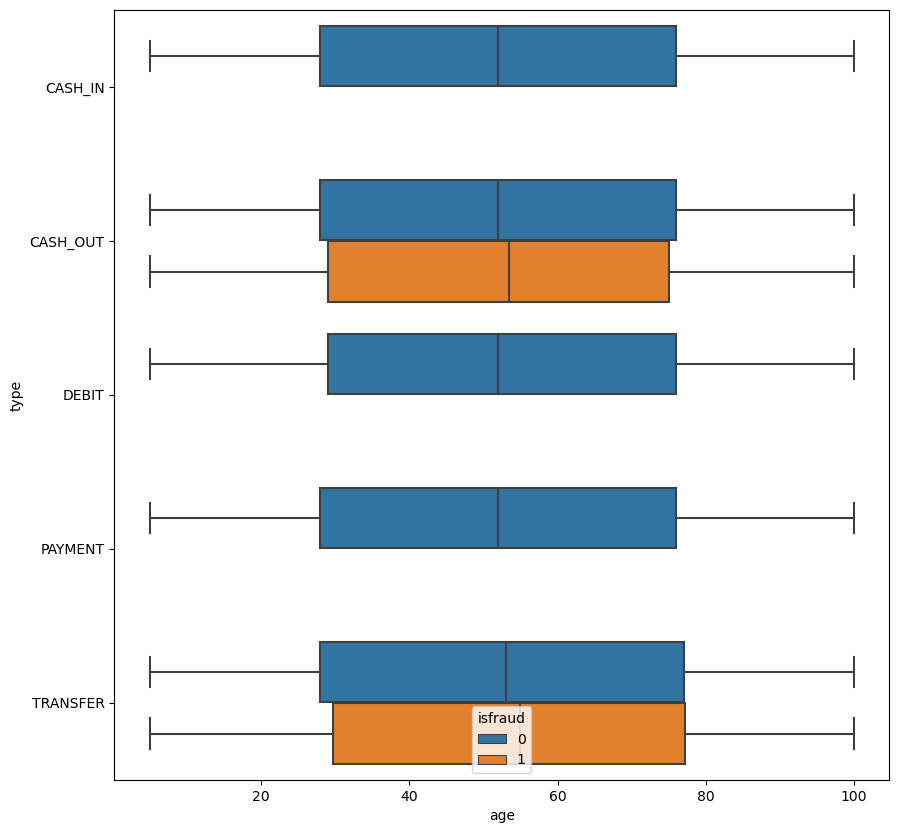

In [76]:
fig, ax = pyplot.subplots(figsize=(10,10))
sns.boxplot(y = 'type', x = 'age', hue='isfraud',data = data_raw)

### User_connections
 

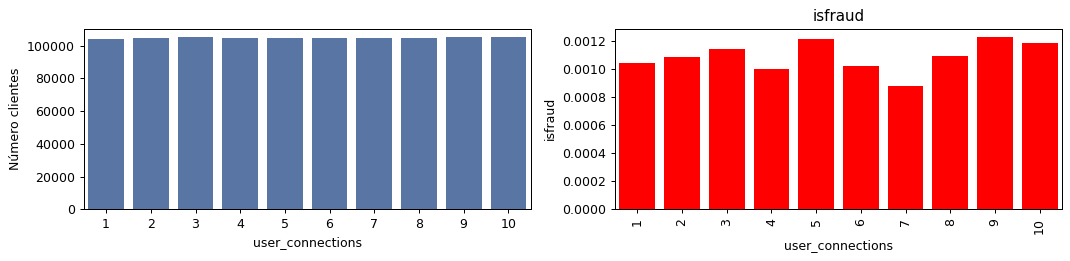

In [77]:
plot_feature(data_raw, 'user_connections')

In [78]:
tabla_value=data_raw.user_connections.value_counts().to_frame()
tabla_value['proporcion']=data_raw.user_connections.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']


tabla_value

,operaciones,proporcion
10,105209,10.0335
9,105159,10.0288
3,105021,10.0156
2,104916,10.0056
7,104914,10.0054
6,104873,10.0015
4,104864,10.0006
5,104770,9.9917
8,104527,9.9685
1,104322,9.9489


In [79]:
data_raw[['user_connections','isfraud']].groupby('user_connections').agg([sum,'mean'])

isfraud       
                     sum   mean
user_connections               
1                    109 0.0010
2                    114 0.0011
3                    120 0.0011
4                    105 0.0010
5                    127 0.0012
6                    107 0.0010
7                     92 0.0009
8                    114 0.0011
9                    129 0.0012
10                   125 0.0012

### Nameorig, Namedest.
De la estructura de los datos inferimos que los nombres que comienzan con C son consumidores y lso que empiezan por M son comerciantes. Los comerciantes son destino de los pyaments que se realizan en tiendas. Decidimos construir un nuevo campo que refleje si son transacciones entre consumidores o consumidor negocio.
Se producen mas operacioens entre particulares, y lso comerciantes no están implicados en ningun caso de fraude, ya que sol oreciben payments, donde no hay fraude.

In [80]:
metadata[metadata.nombre.isin(['nameorig','namedest'])]

,nombre,dtype,tipologia,valores_unicos,5_mas_frecuentes,5_max_ocururrencias
6,nameorig,object,cardinal,1048317,"[C1214450722, C309111136, C1268675361, C720460...","[2, 2, 2, 2, 2]"
13,namedest,object,cardinal,449635,"[C985934102, C1286084959, C1590550415, C248609...","[98, 96, 89, 88, 87]"


In [81]:
tipo_origen=data_raw.nameorig.apply(lambda x: "".join([y[0] for y in (x.split())]))
tipo_destino=data_raw.namedest.apply(lambda x: "".join([y[0] for y in (x.split())]))
data_raw['segmento']=tipo_origen+tipo_destino

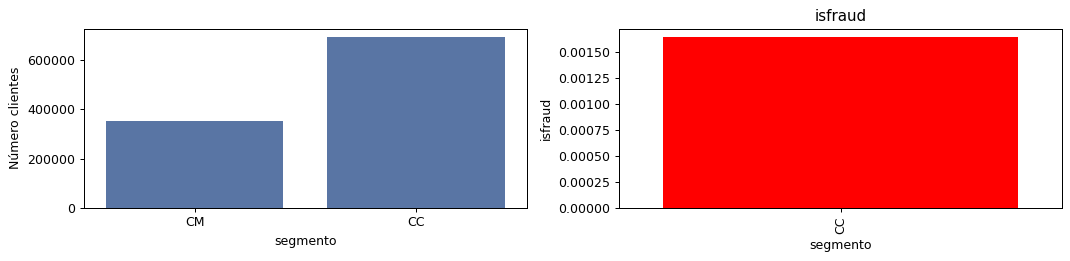

In [82]:
plot_feature(data_raw,'segmento')

In [83]:
tabla_value=data_raw.segmento.value_counts().to_frame()
tabla_value['proporcion']=data_raw.segmento.value_counts(normalize=True).to_list()
tabla_value['proporcion']=100*tabla_value['proporcion']
tabla_value.columns=['operaciones','proporcion']
tabla_value

,operaciones,proporcion
CC,694702,66.2520
CM,353873,33.7480


In [84]:
data_raw[['segmento','isfraud']].groupby('segmento').agg([sum,'mean'])

isfraud       
             sum   mean
segmento               
CC          1142 0.0016
CM             0 0.0000


Existen 1.048.317 clientes emisores para 1.048.317 operaciones. Los clientes realizan poco mas de una operación en estos  4 días. Los receptores son 449.635, dos veces menos que emisores. Solo existen 44 cuentas que emitan y reciban operaciones.



In [85]:
emisores=data_raw['nameorig'].unique()

In [86]:
data_raw.shape

(1048575, 25)

In [87]:
len(emisores)

1048317

In [88]:
receptores=data_raw['namedest'].unique()

In [89]:
len(receptores)

449635

In [90]:
recep_emisor=np.intersect1d(emisores,receptores )

In [91]:
len(recep_emisor)

44

In [92]:
solo_emisor= np.setdiff1d(emisores,recep_emisor , assume_unique=True)

In [93]:
len(solo_emisor)

1048273

In [94]:
solo_receptor= np.setdiff1d(receptores,recep_emisor , assume_unique=True)

In [95]:
len(solo_receptor)+len(solo_emisor)+len(recep_emisor)

1497908

In [96]:
clientes=pd.DataFrame(data_raw.namedest.append(data_raw.nameorig, 
                  ignore_index = True),columns=['clientes']).drop_duplicates()

In [97]:
data_raw[data_raw.nameorig.isin(emisores)]['isfraud'].value_counts()

0    1047433
1       1142
Name: isfraud, dtype: int64

In [98]:
data_raw[data_raw.namedest.isin(receptores)]['isfraud'].value_counts()

0    1047433
1       1142
Name: isfraud, dtype: int64

### Oldbalanceorg, newbalanceorig.

Saldos incciales y finales después de hacer la transacción.
No es casualidad que oldbalanceorg esté en mayusculas, ya que con un tratamiento muy simple se convierte en la llave de construcción de una REGLA DEFINITIVA PARA DISCRIMINAR LOS FRAUDES, lo explicaremos.

Por otro lado, parece que nuestros datos ocultan NaNs encubiertos, dependiendo de sí es una operación de ingreso o retirada OLDBALANCEORG +- AMOUNT, debería ser igual a NEWBALANCORIG, pues no ocurre en todos los casos. Hay cuentas descuadradas, intuimos que pueden ser dos casos:
1) Que se permita dejar las cuentas origen en descubierto.
2) Que hay operaciones que quedaron bloqueadas y no se realizaron.
Ocurrirá lo mismo en las cuentas destino.
Decidimos generar un campo con esa diferencia.

### Patones de fraude:

El fraude tiene un patrón absolutamente predominante, se realiza una transferencia por el total del saldo de la cuenta origen, o parece que el limite de transferencias en cuentas con saldos muy altos, y la siguente operación es un cash_out completo de la cuenta destino de la transferencia.

**EN OPERACIONES DE TRANSFER Y CASH_OUT, CUANDO LA OPERACIÓN IMPLICA TODO EL OLDBALANCEORG, ES FRAUDE.**

Solo los defraudarores realizan vaciados totales de los saldos de las cuentas.

La empresa podría bloquear temporalmente las transferencias que dejan a cero la cuenta origen. No se produce ningun falso positivo. Y sí se intenta inmediatamente un cash_out de todo el saldo destino, no hacerlo y marcar las dos transacciones como fraude.
COn este metodo estamos bordeando el lekeage, tendríamos que esperar a ver si se produce el cash-out.

A nosotros nos permite construir una caracterisitica que detectará el 98 % de lso c




TRANSFERENCIA:
Cuando origina una transferencia de limite permitido y existen saldos en origen para hacerla, con destino a una cuenta que no tiene saldo


CASH-OUT de todo el origen el oldorigin, neworigin==0, y vaciado de toda la cuenta de destino, destnew==0.
No caemso en lekage. Sí se produce un cash-out donde se vacia la totalidad del saldo de la cuenta orgien y la cuenta destino no tiene saldo despues de la operación, marcala como fraude.


In [99]:
check_fraud=data_raw[['step','type','amount','isfraud','oldbalanceorg','newbalanceorig','oldbalancedest','newbalancedest','nameorig', 'namedest','user_number']]

#### Patrón predominate. Control de la cuenta por el delincuente, transferencia por la totalidad del saldo de la cuenta origen. Inmediantamente ( siguiente operación), cash_out de la cuenta destino por la totalidad del importe sutraido.

Bajo este modus-operandi se realizan 1109 operaciones, que suponen 1102 caso de fraude, o lo que es lo mismo el 97 % de todo el fraude cometido.

Pero se extrae otro patrón muy interesante, SOLO LOS DEFRAUDADORES VACIAN LAS CUENTAS EN SU TOTALIDAD. Cuando una operación retira todo el oldbalanceorig es fraude.

In [100]:
# filtrado de pares de operacioens transfer cash_out
check_fraud[(check_fraud.oldbalanceorg == check_fraud.amount) &
            (((check_fraud['type']=='TRANSFER') &  (check_fraud['type'].shift(-1)=='CASH_OUT')) & (check_fraud.amount==check_fraud.amount.shift(-1))) |
              (((check_fraud['type']=='CASH_OUT') &  (check_fraud['type'].shift(1)=='TRANSFER')) & (check_fraud.amount==check_fraud.amount.shift(1)))][['amount','type','isfraud']]

,amount,type,isfraud
2,181.0000,TRANSFER,1
3,181.0000,CASH_OUT,1
251,2806.0000,TRANSFER,1
252,2806.0000,CASH_OUT,1
680,20128.0000,TRANSFER,1
...,...,...,...
1047888,56745.1400,CASH_OUT,1
1048221,33676.5900,TRANSFER,1
1048222,33676.5900,CASH_OUT,1
1048323,87999.2500,TRANSFER,1


In [101]:
check_fraud[check_fraud.oldbalanceorg == check_fraud.amount][['type','isfraud']].groupby('isfraud').count()

,type
isfraud,
1,1109


Hemos construido una función muy simple para que nos marque el vacioado de cuentas con transfer o cash_out. Sin caer en lekaage, nos discrimina las 1109 operacioens fraudulentas.
Utilizamos una matriz de confusión apra validar nuestra REGLA, y observamos que no genera ningun FP , y genera 33 FN, que tendrán que ser los modelos los que ayuden a discriminar.

EN REALIDAD, ESTA MECANICA REPRODUCE LA MANERA lógica de trabajar en el mundo real. La detección de patrones de fraude, permite paralizar ese tip ode operatoria de manera inmediata, frente a los modelos que tendrán que disponer de casos que aporten significancia estadistica para detectarlos.
Tambien es verdad, que los delincuentes, enseguida aprenderán, y en este caso, dejando en la cuenta origen 1 unidad monetaria, la función dejaría de funcionar.

Pero estamos en el laboratorio, seguramente con datos sinteticos, y aqui, nuestra regla tiene un poder para detectar fraude espectacular.

In [102]:
check_fraud['t_c']=check_fraud.apply(check_t_c,axis=1)

In [103]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(check_fraud['t_c'],check_fraud['isfraud']))


[[1047433      33]
 [      0    1109]]


Vamos a añadir nuestra etiqueta de fraude a la tabla de datos.

In [104]:
data_raw['fraud_rules']=check_fraud['t_c'].tolist()
data_raw['fraud_rules']=data_raw['fraud_rules'].astype('category')

In [105]:
data_raw.columns

Index(['step', 'type', 'amount', 'gender', 'device', 'connection_time',
       'nameorig', 'race', 'oldbalanceorg', 'age', 'newbalanceorig', 'zone',
       'user_number', 'namedest', 'user_connections', 'security_alert',
       'oldbalancedest', 'newbalancedest', 'isfraud', 'dia', 'hora',
       'step_order', 'step_importance', 'fraud_order', 'segmento',
       'fraud_rules'],
      dtype='object')

## Transsacciones descuadradas.

Las difernecicias entre old y new balances deberían coincidir en origin o destin con el amount de la operación.

Hay muchas ocasiones que no ocurre. P.E., en payments no se controlan los saldo destino de los comerciantes. Pero en las operacioens relevantes para fraude, Cash_out y transfer, hay veces que todo cuadra, y otras no. No sabemos sí dejan trabajar a cuentas origen en descubierto, aunque no se marquen los saldos en descubierto, o sí estará enmascarados con cero o descuadres valores faltantes operacioens que quedan en intento, y no se realizan.

En las cuentas de origen solo existen 28855 operaciones cuadradas de u ntotal de 460.394, pero agutinan 1113 operacioens fraudulentas ( el 97 % del fraude).
Parece que esta caracteristica puede ayudas a los modelos a aprender. Por otra parte, en las descuadradas siendo 431539, solo acaparan 29 casos de frude.




In [106]:
operaciones_cuadradas=data_raw[(data_raw.oldbalanceorg -data_raw.amount -data_raw.newbalanceorig==0)
 & data_raw['type'].isin(['TRANSFER','CASH_OUT']) ].shape[0]
operaciones_descuadradas=data_raw[(data_raw.oldbalanceorg -data_raw.amount -data_raw.newbalanceorig != 0)
 & data_raw['type'].isin(['TRANSFER','CASH_OUT']) ].shape[0]

In [107]:
operaciones_cuadradas,operaciones_descuadradas,operaciones_cuadradas+operaciones_descuadradas

(28855, 431539, 460394)

In [108]:
cuadradas= data_raw[(data_raw.oldbalanceorg -data_raw.amount -data_raw.newbalanceorig==0)
 & data_raw['type'].isin(['TRANSFER','CASH_OUT']) ]['isfraud'].to_frame()
 
cuadradas_perc=cuadradas['isfraud'].value_counts(normalize= True).mul(100).reset_index()

cuadradas_isfraud_conteo= cuadradas['isfraud'].value_counts(normalize=False).reset_index()

cuadradas_isfraud_pc = pd.merge(cuadradas_perc,cuadradas_isfraud_conteo,
                              on=['index'], how='inner').rename(columns={'index':'valor','isfraud_x':'porcent_total','isfraud_y':'numero'}).drop('valor',axis=1)

cuadradas_isfraud_pc


,porcent_total,numero
0,96.1428,27742
1,3.8572,1113


In [109]:
descuadradas= data_raw[(data_raw.oldbalanceorg -data_raw.amount -data_raw.newbalanceorig!=0)
 & data_raw['type'].isin(['TRANSFER','CASH_OUT']) ]['isfraud'].to_frame()
 
descuadradas_perc=descuadradas['isfraud'].value_counts(normalize= True).reset_index()

descuadradas_isfraud_conteo= descuadradas['isfraud'].value_counts(normalize=False).reset_index()

descuadradas_isfraud_pc = pd.merge(descuadradas_perc,descuadradas_isfraud_conteo,
                              on=['index'], how='inner').rename(columns={'index':'valor','isfraud_x':'porcent','isfraud_y':'numero'}).drop('valor',axis=1)
descuadradas_isfraud_pc


,porcent,numero
0,0.9999,431510
1,0.0001,29


Repitamos el ejercicio para las cuwentas destino:

Todos los fraudes están en cuentas donde el computo del balance de la cuenta destino está descuadrado. PArece que tambien nos puede ayudar a discernir el fraude.

In [110]:
operaciones_cuadradas=data_raw[(data_raw.oldbalancedest +data_raw.amount -data_raw.newbalancedest==0)
 & data_raw['type'].isin(['TRANSFER','CASH_OUT']) ].shape[0]
operaciones_descuadradas=data_raw[(data_raw.oldbalancedest +data_raw.amount -data_raw.newbalancedest != 0)
 & data_raw['type'].isin(['TRANSFER','CASH_OUT']) ].shape[0]

In [111]:
operaciones_cuadradas,operaciones_descuadradas,operaciones_cuadradas+operaciones_descuadradas

(198822, 261572, 460394)

In [112]:
cuadradas= data_raw[(data_raw.oldbalancedest -data_raw.amount -data_raw.newbalancedest!=0)
 & data_raw['type'].isin(['TRANSFER','CASH_OUT']) ]['isfraud'].to_frame()
 
cuadradas_perc=cuadradas['isfraud'].value_counts(normalize= True).mul(100).reset_index()

cuadradas_isfraud_conteo= cuadradas['isfraud'].value_counts(normalize=False).reset_index()

cuadradas_isfraud_pc = pd.merge(cuadradas_perc,cuadradas_isfraud_conteo,
                              on=['index'], how='inner').rename(columns={'index':'valor','isfraud_x':'porcent_total','isfraud_y':'numero'}).drop('valor',axis=1)

cuadradas_isfraud_pc

,porcent_total,numero
0,99.7520,459252
1,0.2480,1142


Incorporamos como nuevos features los importes de los balances de las cuentas origen y destino. En caso de estar cuadradas será igual a 0.

In [113]:
map_sig_orig={'CASH_OUT':-1,
         'TRANSFER':-1,
         'PAYMENT': -1,
         'CASH_IN': 1,
         'DEBIT': -1
         }
map_sig_dest={'CASH_OUT':-1,
         'TRANSFER': +1,
         'PAYMENT': 1,
         'CASH_IN': -1,
         'DEBIT': 1
         }

In [114]:
data_raw['errorbalanceorig'] = data_raw['type'].map(map_sig_orig)*(data_raw.newbalanceorig - data_raw.oldbalanceorg)  - data_raw.amount
data_raw['errorbalancedest'] = data_raw['type'].map(map_sig_dest)*(data_raw.oldbalancedest - data_raw.newbalancedest)  + data_raw.amount

In [115]:
fraud = data_raw[data_raw["isfraud"] == 1]
valid = data_raw[data_raw["isfraud"] == 0]

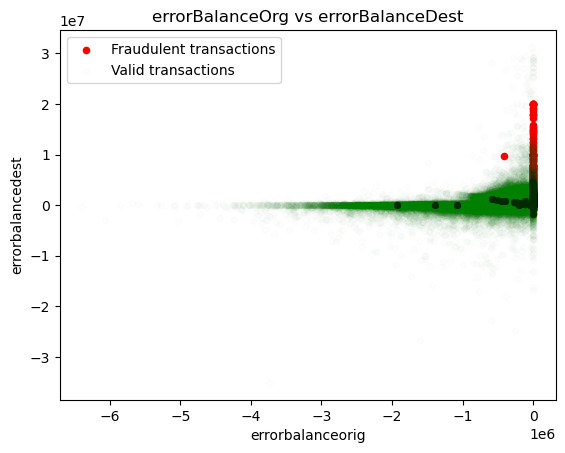

In [116]:
fraud = data_raw[data_raw["isfraud"] == 1]
valid = data_raw[data_raw["isfraud"] == 0]
errors = ["'errorbalanceorig", "errorbalancedest"]

ax = plt.subplot()

fplot = fraud.plot(x="errorbalanceorig",y="errorbalancedest",color="red",kind="scatter",ax=ax,label="Fraudulent transactions")
vplot = valid.plot(x="errorbalanceorig",y="errorbalancedest",color="green",kind="scatter",\
                   alpha=0.01,ax=ax,label="Valid transactions")
plt.title("errorBalanceOrg vs errorBalanceDest")
plt.show()

In [117]:
# Guardamos en disco los datos limpios.
data_raw.to_parquet('../data/fraud_detection_engineering.parquet',
              compression='gzip')

### Conclusión EDA.
Hemso estudiado laas caracteristicas, hemos concluido patrones muy claros del fraude. Pasamos a las sigueinte fase de estudio de correlaciones y selección de caracterisiticas relevantes para nuestro modelo en el siguiente cuaderno.